Unsupervised Sentiment Analysis on Twitter Posts
================================================

Process Raw Tweets into cleaned Tweets (13 min Execution Time)
--------------------------------------

In [1]:
# handle imports
import pandas as pd
from TweetProcessor import TweetProcessor

# read in raw tweets from csv
raw_tweets = pd.read_csv("_resources/tweets/raw_tweets.csv")

# clean all the tweets (computationally expensive)
clean_tweets = raw_tweets.apply(lambda row: TweetProcessor.cleanTweet(row['content']), axis=1, result_type='broadcast')

# save the clean tweets
clean_tweets.to_csv('_resources/tweets/clean_tweets.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Domin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Domin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Build FastText Model and Kmeans Clustering Model (4 min Execution Time)
------------------------------------------------

In [22]:
# handle imports
import pandas as pd

import multiprocessing
from gensim.models import FastText
from sklearn.cluster import KMeans

from joblib import dump, load

from TweetProcessor import TweetProcessor

# create a TweetProcessor
tweet_processor = TweetProcessor()

# build fasttext model
cpu_count = multiprocessing.cpu_count()

fasttext_model = FastText(min_count=10,
                     window=4,
                     vector_size=50,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=30,
                     workers=cpu_count-1)

fasttext_model.build_vocab(tweet_processor.phrases)

# train the fasttext model
fasttext_model.train(tweet_processor.phrases, total_examples=fasttext_model.corpus_count, epochs=30)

# define centroids
centroids = np.array([fasttext_model.wv.get_vector('happy'), fasttext_model.wv.get_vector('sad'), fasttext_model.wv.get_vector('okay')])

# build kmeans model
km_model = KMeans(n_clusters=3, max_iter=2000, init=centroids)

# train a kmeans model for fasttext vectorization strategy
km_model_fasttext = km_model.fit(X=fasttext_model.wv.vectors)

# save the fasttext model
fasttext_model.save('_resources/models/fasttext.model')

# save the kmeans model
dump(km_model_fasttext, '_resources/models/km_fasttext.model')

C:\Users\Domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1149: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


['_resources/models/km_fasttext.model']

Perform Dimensionality Reduction on the Cluster Data (<1 min Execution Time)
----------------------------------------------------

In [27]:
# handle imports
from gensim.models import FastText

from joblib import load

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# load the fasttext model
fasttext_model = FastText.load('_resources/models/fasttext.model')

# load the kmeans model
km_model_fasttext = load('_resources/models/km_fasttext.model')

# pretty variables for the clusters
cluster_labels = ['positive_cluster', 'negative_cluster', 'neutral_cluster']

# define a function for getting cluster labels
get_cluster_label = np.vectorize(lambda cluster: cluster_labels[cluster])

# get cluster labels for the word2vec kmeans model
fasttext_clusters = get_cluster_label(km_model_fasttext.predict(fasttext_model.wv.vectors))
fasttext_vectors = fasttext_model.wv.vectors

# prepare fasttext dataframe for simple plotting
fasttext_df = pd.DataFrame(fasttext_vectors)
fasttext_df['clusters'] = fasttext_clusters

# perform PCA dimensionality reduction on fasttext
pca = PCA(n_components=3)
fasttext_pca_result = pca.fit_transform(fasttext_vectors)

# perform TSNE dimensionality reduction on fasttext
tsne = TSNE(n_components=2, perplexity=50, n_iter=300)
fasttext_tsne_results = tsne.fit_transform(fasttext_pca_result)

# store fasttext PCA results in the dataframe
fasttext_df['tsne-2d-one'] = fasttext_tsne_results[:,0]
fasttext_df['tsne-2d-two'] = fasttext_tsne_results[:,1]

# save the reduced fasttext cluster data
fasttext_df.to_csv('_resources/clusters/fasttext_reduced_clusters.csv', index=False)

C:\Users\Domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Domin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Plot the Clusters using Seaborn (<1 min Execution Time)
-------------------------------

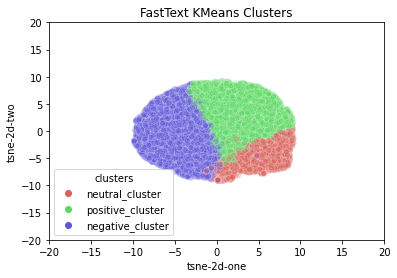

In [28]:
# handle imports
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# load the reduced fasttext cluster data
fasttext_df = pd.read_csv('_resources/clusters/fasttext_reduced_clusters.csv')

# plot the fasttext clusters
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="clusters",
    palette=sns.color_palette("hls", 3),
    data=fasttext_df,
    legend="full",
    alpha=0.3
)

# give the fasttext subplot a title
plt.title('FastText KMeans Clusters')

# adjust view
plt.xlim([-20, 20])
plt.ylim([-20, 20])

# save fasttext figure
plt.savefig('_resources/clusters/kmeans_clusters.png')

Define a Prediction Function and Test on Actual Tweets (<1 min Execution Time)
--------------------------------------------------------

In [30]:
# handle imports
from TweetProcessor import TweetProcessor

import scipy as sp

# define an analyzing function
def analyze_sentiment(tweet):
    # phrase the tweet
    phrases = tweet_processor.phrase_model[tweet.split()]
    
    #if no text was provided, default to neutral
    if(len(phrases) == 0):
        return 1

    # predict sentiment using fasttext clusters
    fasttext_vector = fasttext_model.wv[phrases]
    fasttext_res = km_model_fasttext.predict(fasttext_vector)
    fasttext_mode = int(sp.stats.mode(fasttext_res)[0])

    # get counts
    neu = list(fasttext_res).count(0)
    neg = list(fasttext_res).count(1)
    pos = list(fasttext_res).count(2)

    # if pos == neg result is neutral
    if(pos == neg):
        return 0

    # if neu == (pos || neg) result is (pos || neg)
    if(neu == pos and pos > neg):
        return 2
    if(neu == neg and neg > pos):
        return 1

    # else result is mode
    return fasttext_mode

# pretty variables for the clusters
cluster_labels = ['positive_cluster', 'negative_cluster', 'neutral_cluster']

# get some tweets from twitter
tweets = [
    'Tensions rise between Rittenhouse supporters and protestors as the first day of jury deliberations comes to a close without a verdict in Kenosha, WI on 11.16.21',
    'It really saddens me that Kyle is referred to as a “kid who had to defend himself” by people who had no sympathy for Trayvon, who was walking home, unarmed and un-white.',
    'this sucks',
    'AHHHHHH @ArianaGrande she is truly the kindest most humble human I’ve met 👑❤️🥰',
    'When you\'re happy and in a good place with yourself, with others and life in general, good things tend to happen. 🚀🌙🚀 Dogecoin',
    'this is cool 😊',
    'Mr. Jenners planned to move his family to New York.',
    'We\'re niether happy nor sad to hear that.',
    'this is fine',
    'Realmente me entristece que Kyle sea referido como un “niño que tuvo que defenderse” por personas que no simpatizaban con Trayvon, quien caminaba a casa, desarmado y no blanco.',
    'Cuando estás feliz y en un buen lugar contigo mismo, con los demás y con la vida en general, tienden a suceder cosas buenas. 🚀🌙🚀 Dogecoin',
    'No estamos felices ni tristes de escuchar eso.'
]

# define the expected sentiment
targets = [
    1,
    1,
    1,
    0,
    0,
    0,
    2,
    2,
    2,
    2,
    2,
    2
]

# predict and output results for negative tweets
print("\n😠 😠 😠 Predicting on Negative Tweets:\n")
for index, tweet in enumerate(tweets[:3]):
    predict = analyze_sentiment(TweetProcessor.cleanTweet(tweet))
    target = targets[index]
    print(tweet.ljust(75))
    print(cluster_labels[predict], cluster_labels[target], ('\t✔️' if predict == target else '\t❌'))
    print()

# predict and output results for positive tweets
print("\n😊 😊 😊 Predicting on Positive Tweets:\n")
for index, tweet in enumerate(tweets[3:6]):
    predict = analyze_sentiment(TweetProcessor.cleanTweet(tweet))
    target = targets[index + 3]
    print(tweet.ljust(75))
    print(cluster_labels[predict], cluster_labels[target], ('\t✔️' if predict == target else '\t❌'))
    print()

# predict and output results for neutral tweets
print("\n😐 😐 😐 Predicting on Neutral Tweets:\n")
for index, tweet in enumerate(tweets[6:9]):
    predict = analyze_sentiment(TweetProcessor.cleanTweet(tweet))
    target = targets[index + 6]
    print(tweet.ljust(75))
    print(cluster_labels[predict], cluster_labels[target], ('\t✔️' if predict == target else '\t❌'))
    print()

# Demonstrate problem with neutral cluster
print("\n🇪🇸 🇪🇸 🇪🇸 Predicting on Spanish Tweets (Neutral Cluster? More like Spanish Cluster):\n")
for index, tweet in enumerate(tweets[9:]):
  predict = analyze_sentiment(TweetProcessor.cleanTweet(tweet))
  target = targets[index + 9]
  print(tweet.ljust(75))
  print(cluster_labels[predict], cluster_labels[target], ('\t✔️' if predict == target else '\t❌'))
  print()


😠 😠 😠 Predicting on Negative Tweets:

Tensions rise between Rittenhouse supporters and protestors as the first day of jury deliberations comes to a close without a verdict in Kenosha, WI on 11.16.21
negative_cluster negative_cluster 	✔️

It really saddens me that Kyle is referred to as a “kid who had to defend himself” by people who had no sympathy for Trayvon, who was walking home, unarmed and un-white.
negative_cluster negative_cluster 	✔️

this sucks                                                                 
positive_cluster negative_cluster 	❌


😊 😊 😊 Predicting on Positive Tweets:

AHHHHHH @ArianaGrande she is truly the kindest most humble human I’ve met 👑❤️🥰
positive_cluster positive_cluster 	✔️

When you're happy and in a good place with yourself, with others and life in general, good things tend to happen. 🚀🌙🚀 Dogecoin
positive_cluster positive_cluster 	✔️

this is cool 😊                                                             
positive_cluster positive_cluster 	✔️

